In [1]:
import numpy as np
from metasense.data import load_board
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
sns.set_style('white')

In [67]:
def train_classifier(cf, features, target):
    X, Y = X_train[features], X_train[target]
    X_, Y_ = X_test[features], X_test[target]
    cf.fit(X_train[features], X_train[target])
    Y_pred = cf.predict(X_)
    return cf, (mean_absolute_error(Y, cf.predict(X)), mean_absolute_error(Y_, Y_pred))
def plot_columns(cf, features, gas):
    cf, results = train_classifier(cf, features, "epa-%s" % gas)
    fig, ax = plt.subplots(2)
    plt.suptitle(gas)
    ax[0].set_title('Training Data')
    X_train['%s-pred' % gas] = cf.predict(X_train[features])
    X_train[['%s-pred' % gas, 'epa-%s'%gas]].plot(ax=ax[0], alpha=0.8)
    ax[1].set_title('Test Data')
    X_test['%s-pred' % gas] = cf.predict(X_test[features])
    X_test[['%s-pred' % gas, 'epa-%s'%gas]].plot(ax=ax[1], alpha=0.8)
    print("MAE:", *results)
    print("CvMAE", results[0] / X_train['epa-%s'%gas].mean(), results[1] / X_test['epa-%s'%gas].mean())
    plt.show()

# Donovan

### Board 17

MAE: 4.03056578621 3.93651313892
CvMAE 0.107604659388 0.105589004242


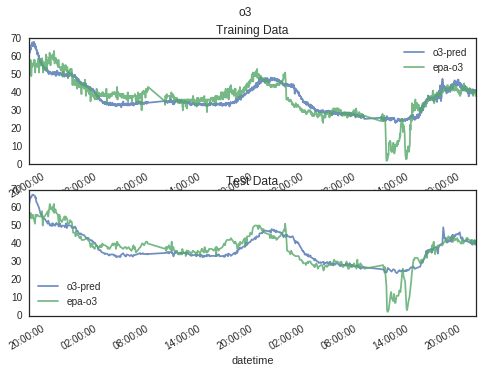

MAE: 2.26757217988 2.23980554096
CvMAE 0.544350555825 0.547976377


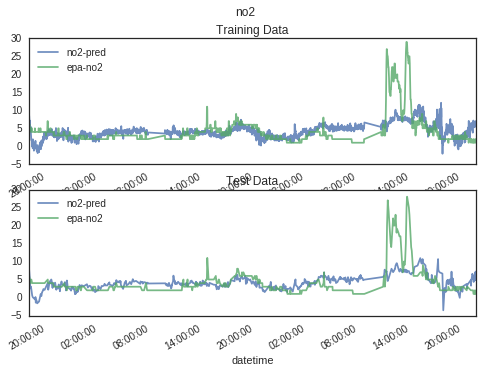

In [68]:
X_train, X_test = load_board('donovan17', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

### Board 19

MAE: (4.1891633027063522, 4.217741078574222)


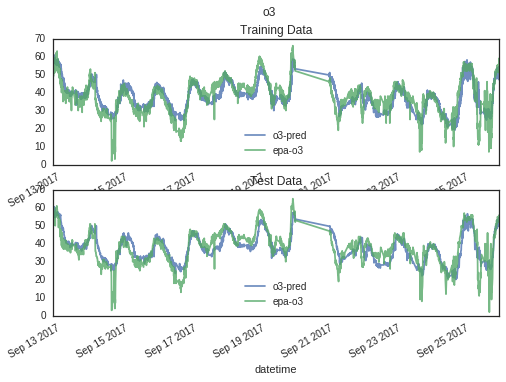

MAE: (2.9228286148659044, 2.9732489020903587)


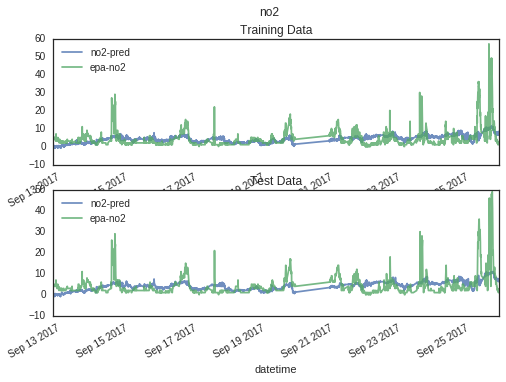

In [40]:
X_train, X_test = load_board('donovan19', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

### Board 21

MAE: 4.32491139174 4.25956339891
CvMAE 0.114121593559 0.111962719833


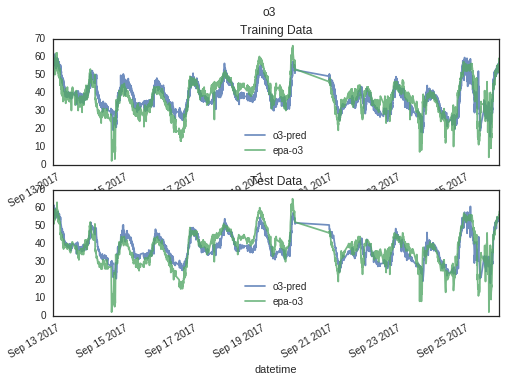

MAE: 2.53978011998 2.55424266153
CvMAE 0.601142610343 0.612662623869


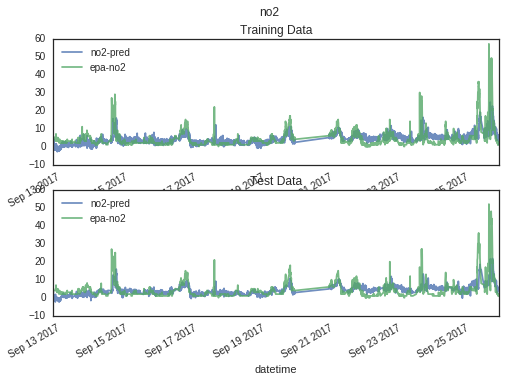

In [80]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

# El Cajon

### Board 11

MAE: (45.857257767562267, 47.637346493922152)


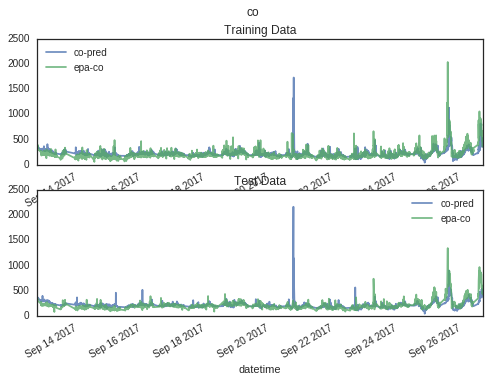

MAE: (8.1559037636581788, 8.2034690465484523)


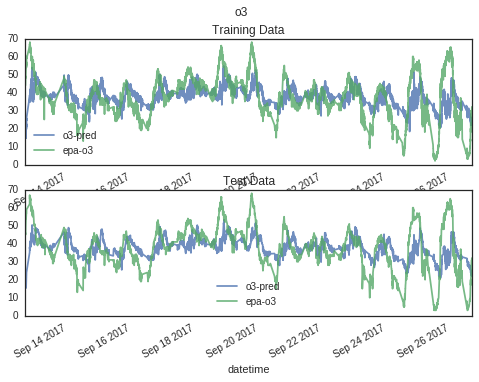

In [50]:
X_train, X_test = load_board('elcajon11', sd=True)
plot_columns(LinearRegression(), ['co'], 'co')
plot_columns(LinearRegression(), ['o3'], 'o3')

### Board 12

MAE: (47.195694404583051, 44.34522379706091)


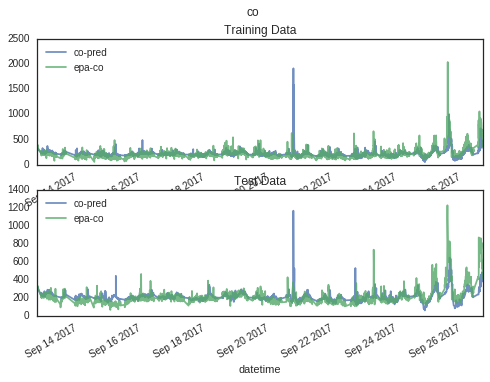

MAE: (6.360324807615517, 6.287895460788981)


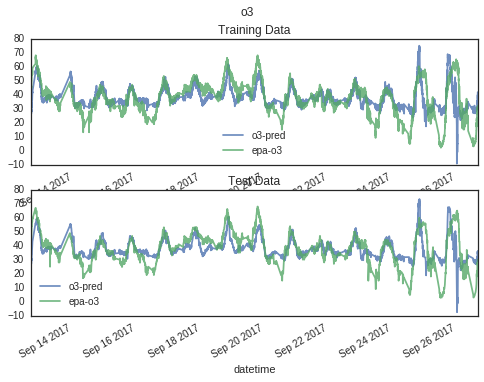

In [51]:
X_train, X_test = load_board('elcajon12', sd=True)
plot_columns(LinearRegression(), ['co'], 'co')
plot_columns(LinearRegression(), ['o3'], 'o3')

### Board 13

MAE: 45.1182569406 45.864857
CvMAE 0.215080533778 0.213944244803


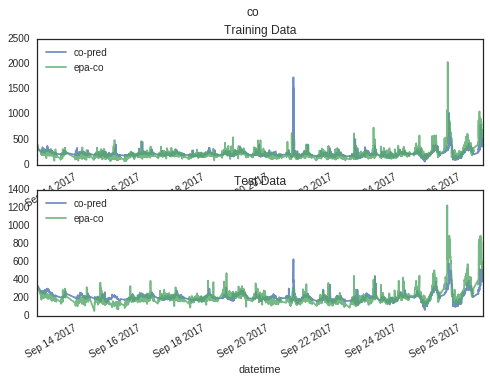

MAE: 5.71407628443 5.88928650937
CvMAE 0.151023809145 0.155533027156


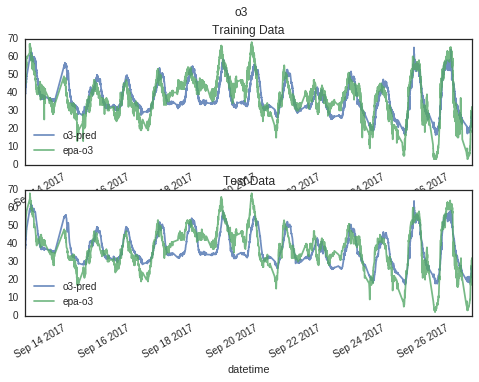

In [77]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(LinearRegression(), ['co'], 'co')
plot_columns(LinearRegression(), ['o3', 'temperature'], 'o3')

# Random Forest

MAE: 23.2088724141 48.2954289707
CvMAE 0.109922283361 0.231169871969


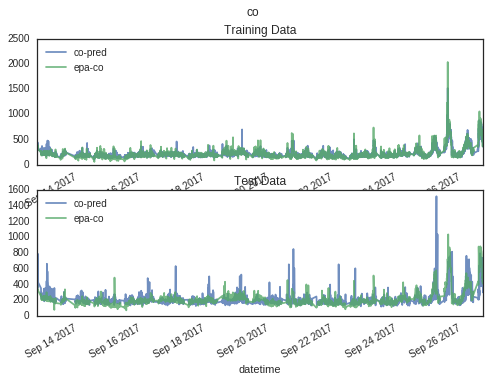

MAE: 1.53535181983 4.15048184571
CvMAE 0.0406253942319 0.109120030469


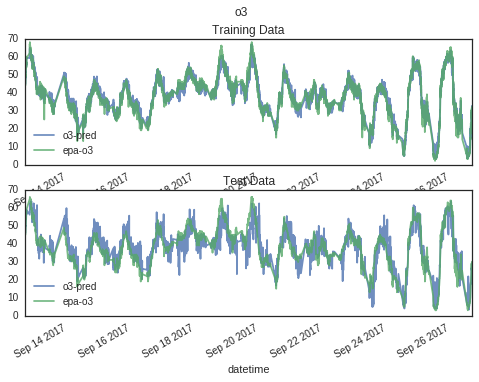

In [76]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(RandomForestRegressor(200), ['co'], 'co')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature'], 'o3')

MAE: 0.980503681275 2.73167910095
CvMAE 0.0258039601728 0.0725712792169


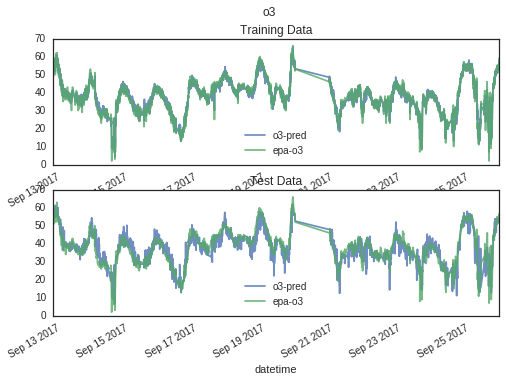

MAE: 0.309577287066 0.83970977918
CvMAE 0.0737310293013 0.196477708887


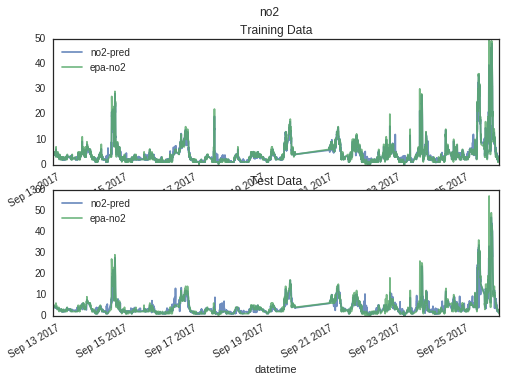

In [79]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

# Intervals

In [20]:
model = LinearRegression()
def train_classifier(cf, features, target):
    cf = IcpRegressor(NcFactory.create_nc(cf))
    X, Y = X_train[features], X_train[target]
    X, X_valid, Y, y_valid = train_test_split(X, Y)
    X_, Y_ = X_test[features], X_test[target]
    cf.fit(X.as_matrix(), Y.as_matrix())
    cf.calibrate(X_valid.as_matrix(), y_valid.as_matrix())
    #Y_pred = cf.predict(X_.as_matrix(), significance=0.05)
    return cf
def plot_columns(cf, features, gas, confidence=0.95):
    cf  = train_classifier(cf, features, "epa-%s" % gas)
    train_results = cf.predict(X_train[features].as_matrix(), significance=1 - confidence)
    test_results = cf.predict(X_test[features].as_matrix(), significance=1 - confidence)

    X_train['lower-%s'%gas], X_train['upper-%s'%gas] = train_results[:, 0], train_results[:, 1]
    X_test['lower-%s'%gas], X_test['upper-%s'%gas] = test_results[:, 0], test_results[:, 1]
    X_train['%s-in-interval'%gas] = (X_train['lower-%s'%gas] <= X_train['epa-%s'%gas]) & (X_train['epa-%s'%gas] <= X_train['upper-%s'%gas])
    X_test['%s-in-interval'%gas] = (X_test['lower-%s'%gas] <= X_test['epa-%s'%gas]) & (X_test['epa-%s'%gas] <= X_test['upper-%s'%gas])
    print("Width:", (X_train['upper-%s'%gas] - X_train['lower-%s'%gas]).mean(),(X_test['upper-%s'%gas] - X_test['lower-%s'%gas]).mean())
    print("Accuracy:", X_train['%s-in-interval'%gas].mean(), X_test['%s-in-interval'%gas].mean())
    fig, ax = plt.subplots(2)
    plt.suptitle(gas)
    ax[0].set_title('Training Data')
    ax[0].fill_between(X_train.index.values, X_train['lower-%s'%gas], X_train['upper-%s'%gas], alpha=0.4)
    X_train['epa-%s'%gas].plot(ax=ax[0], alpha=0.8)
    ax[1].set_title('Test Data')
    X_test['epa-%s'%gas].plot(ax=ax[1], alpha=0.8)
    ax[1].fill_between(X_test.index.values, X_test['lower-%s'%gas], X_test['upper-%s'%gas], alpha=0.4)
    plt.show()


Width: 236.799304082 236.799304082
Accuracy: 0.946021146355 0.949125596184


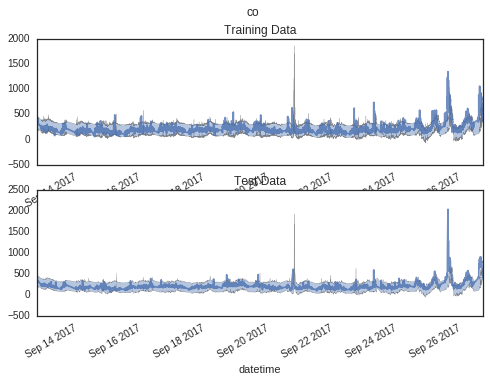

Width: 27.2756451995 27.2756451995
Accuracy: 0.948883059067 0.952623211447


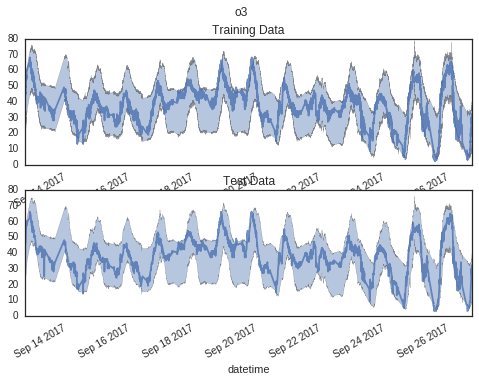

In [22]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(LinearRegression(), ['co'], 'co', confidence=0.95)
plot_columns(LinearRegression(), ['o3', 'temperature'], 'o3')

Width: 307.727 307.727
Accuracy: 0.983067016456 0.952623211447


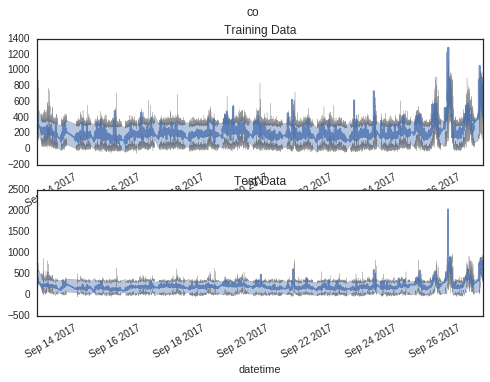

Width: 24.16 24.16
Accuracy: 0.987518880674 0.952623211447


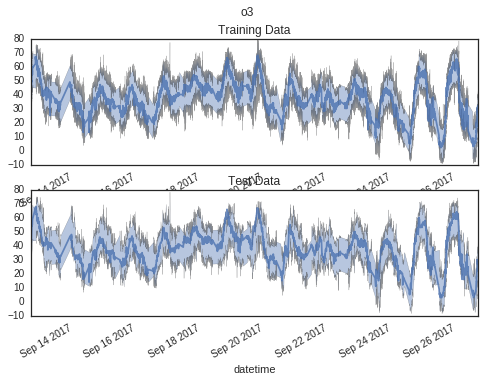

In [24]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(RandomForestRegressor(200), ['co'], 'co')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature'], 'o3')

Width: 19.919542852 19.919542852
Accuracy: 0.941798107256 0.93596214511


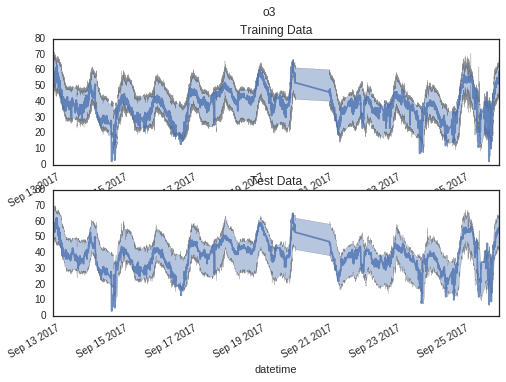

Width: 12.52220324 12.52220324
Accuracy: 0.949842271293 0.947318611987


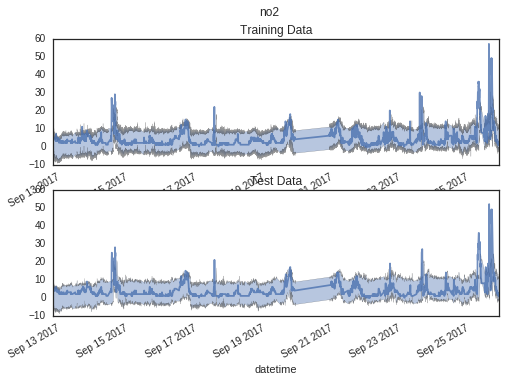

In [25]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

Width: 16.51 16.51
Accuracy: 0.986750788644 0.953312302839


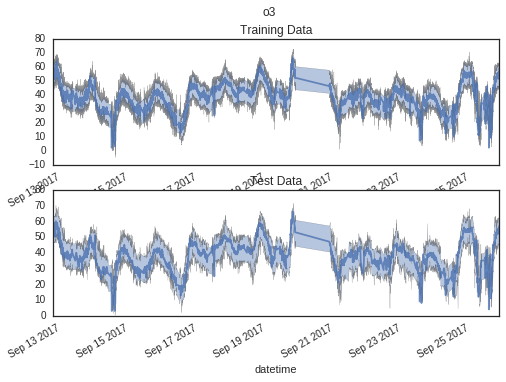

Width: 6.07 6.07
Accuracy: 0.980441640379 0.944794952681


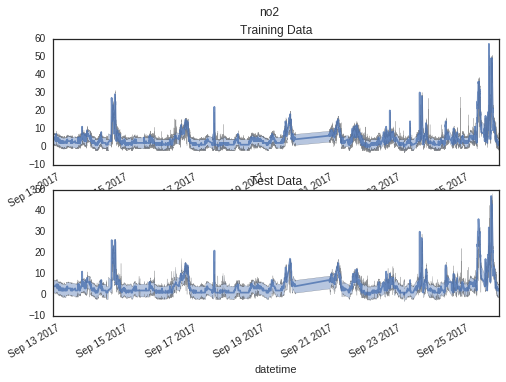

In [26]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2', 'humidity'], 'no2')